In [1]:
from helper_functions import *
import tensorflow as tf
import numpy as np

# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision Mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now its time to scale up to all of the classes in Food101 (101 total food classes)

In [2]:
#Unzip the dataset
unzip_data('101_food_classes_10_percent.zip')

In [3]:
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

In [10]:
IMG_SIZE = (224,224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir, image_size=IMG_SIZE, label_mode='categorical')
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, image_size=IMG_SIZE, label_mode='categorical', shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


poutine
101_food_classes_10_percent/train/poutine
3630145.jpg
101_food_classes_10_percent/train/poutine/3630145.jpg


(-0.5, 511.5, 511.5, -0.5)

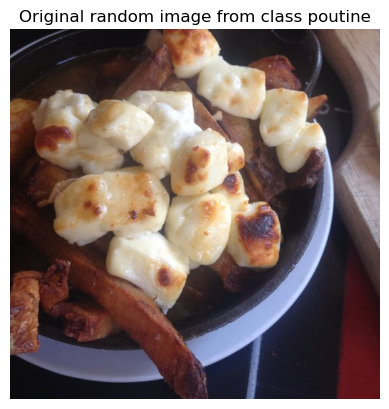

In [12]:
#Visualize, visualize, visualize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

#Get a random class name to find the directory
target_class = random.choice(train_data.class_names)
print(target_class)

#Get a directory using the target class
target_dir = '101_food_classes_10_percent/train/' + target_class
print(target_dir)

#Choose an image at random within that directory
random_image = random.choice(os.listdir(target_dir))
print(random_image)

#Get the full directory for that random image 
random_image_path = target_dir + '/' + random_image
print(random_image_path)

#Show the random image using the file path
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'Original random image from class {target_class}')
plt.axis(False)

## Train our big dog model with transfer learning on 10% of 101 food classes

* A ModelCheckpoint callback so we can get a baseline for our feature extraction
* Create a data augmentation layer to put data augmentation straight into the model
* Build a headless (no top layers) Functional EfficientNetB0 backbone (we'll create our own ouput layer)
* Compile the model
* Feature extract (5 epochs on the train data and validation on 15% of the test data to save epoch time)
* Save the weights to a checkpoint
* Call the model on that checkpoint then unfreeze the last x layers of the base model
* Reduce learning rate by 10x
* Recompile and run for another 5 epochs (dont forget inital_epoch argument)

In [13]:
checkpoint_path = '101_classes_10_percent_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor='val_accuracy', save_best_only=True)

In [14]:
#Create data augmentation layers
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.) #Rescale inputs of images but not needed for efficientnet since this is already in the model
])

In [15]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224,224,3))
data_augmented = data_augmentation(inputs)
x = base_model(data_augmented, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(101, activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)

In [16]:
model_1.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.legacy.Adam(), metrics=['accuracy'])

history_1 = model_1.fit(train_data, epochs=5, validation_data=test_data, validation_steps=int(0.15 * len(test_data)), callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 84s 347ms/step - loss: 3.5301 - accuracy: 0.2371 - val_loss: 2.6789 - val_accuracy: 0.4261
Epoch 2/5
237/237 [==============================] - 85s 357ms/step - loss: 2.4281 - accuracy: 0.4486 - val_loss: 2.1950 - val_accuracy: 0.4812
Epoch 3/5
237/237 [==============================] - 86s 363ms/step - loss: 2.0487 - accuracy: 0.5125 - val_loss: 2.0162 - val_accuracy: 0.5066
Epoch 4/5
237/237 [==============================] - 87s 366ms/step - loss: 1.8331 - accuracy: 0.5589 - val_loss: 1.9517 - val_accuracy: 0.5048
Epoch 5/5
237/237 [==============================] - 87s 368ms/step - loss: 1.6916 - accuracy: 0.5842 - val_loss: 1.8434 - val_accuracy: 0.5312


In [17]:
fine_tuning_results = model_1.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 191s 241ms/step - loss: 1.6291 - accuracy: 0.5704


[1.6290944814682007, 0.5704158544540405]

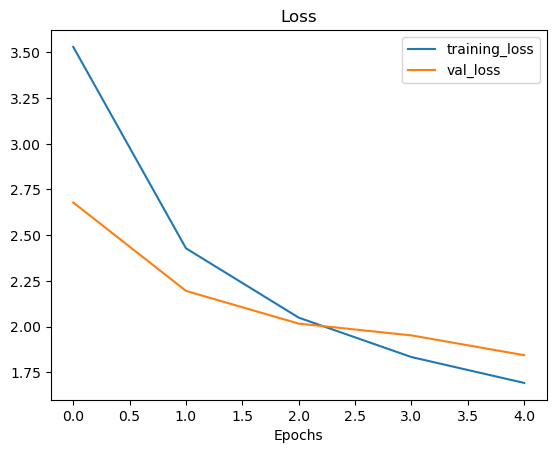

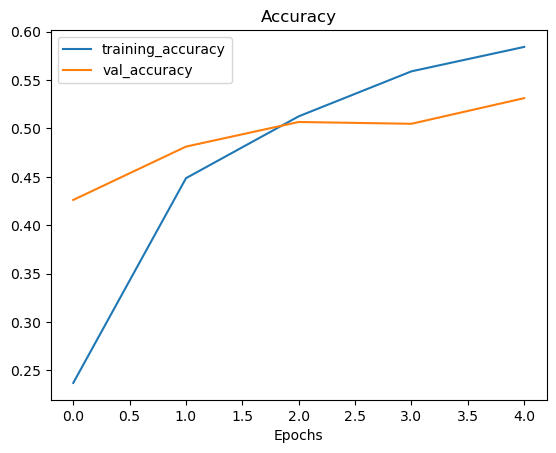

In [18]:
plot_loss_curves(history_1)

In [19]:
#Unfreeze all the layers
base_model.trainable = True

#Refreeze all layers except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [20]:
model_1.load_weights(checkpoint_path)

for i, layer in enumerate(model_1.layers):
    print(i, layer.name, layer.trainable)

0 input_2 True
1 sequential True
2 efficientnetv2-b0 True
3 global_average_pooling2d True
4 dense True


In [21]:
model_1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=.0001), metrics=['accuracy'])

history_2 = model_1.fit(train_data, epochs=10, initial_epoch=history_1.epoch[-1], validation_data=test_data, validation_steps=int(0.15 * len(test_data)),
                       callbacks=[checkpoint_callback])

Epoch 5/10
237/237 [==============================] - 87s 358ms/step - loss: 1.4877 - accuracy: 0.6305 - val_loss: 1.7919 - val_accuracy: 0.5281
Epoch 6/10
237/237 [==============================] - 85s 358ms/step - loss: 1.3943 - accuracy: 0.6354 - val_loss: 1.7827 - val_accuracy: 0.5291
Epoch 7/10
237/237 [==============================] - 89s 376ms/step - loss: 1.3182 - accuracy: 0.6581 - val_loss: 1.7704 - val_accuracy: 0.5315
Epoch 8/10
237/237 [==============================] - 86s 361ms/step - loss: 1.2857 - accuracy: 0.6655 - val_loss: 1.7722 - val_accuracy: 0.5326
Epoch 9/10
237/237 [==============================] - 86s 364ms/step - loss: 1.2471 - accuracy: 0.6655 - val_loss: 1.7637 - val_accuracy: 0.5376
Epoch 10/10
237/237 [==============================] - 87s 369ms/step - loss: 1.2165 - accuracy: 0.6772 - val_loss: 1.7230 - val_accuracy: 0.5453


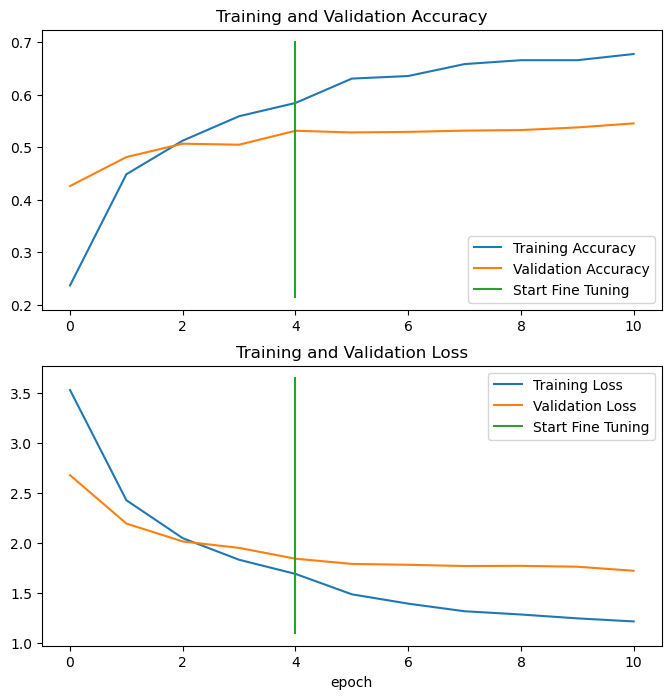

In [22]:
compare_historys(history_1, history_2)

In [23]:
model_1.evaluate(test_data)

790/790 [==============================] - 178s 225ms/step - loss: 1.4745 - accuracy: 0.6057


[1.4744893312454224, 0.6057029962539673]

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere

In [24]:
model_1.save('drive/101_food_classes_10_percent')

INFO:tensorflow:Assets written to: drive/101_food_classes_10_percent/assets


INFO:tensorflow:Assets written to: drive/101_food_classes_10_percent/assets


In [27]:
loaded_model = tf.keras.models.load_model('drive/101_food_classes_10_percent/')

In [28]:
#Evaluate loaded model to compare performace to presaved model
loaded_model.evaluate(test_data)

790/790 [==============================] - 169s 213ms/step - loss: 1.4745 - accuracy: 0.6057


[1.4744893312454224, 0.6057029962539673]

## Evaluating the performance of the big model across all different classes

Let's make some predictions, visualize them and then later find out which predictions were the 'most' wrong

In [29]:
pred_probs = model_1.predict(test_data, verbose=1)

790/790 [==============================] - 169s 213ms/step


In [30]:
len(pred_probs)

25250

In [31]:
pred_probs.shape

(25250, 101)

In [32]:
pred_probs[:10]

array([[1.20966078e-03, 3.27789166e-05, 3.34303647e-01, ...,
        5.23346444e-06, 3.28018534e-04, 2.96763574e-05],
       [7.60074854e-01, 1.12660324e-07, 7.56521150e-03, ...,
        6.27528934e-04, 3.87543651e-06, 1.23620470e-04],
       [5.56272507e-01, 4.22285695e-04, 1.92925390e-02, ...,
        2.46502017e-03, 6.64087362e-04, 1.94331468e-03],
       ...,
       [1.24837607e-01, 1.14803470e-06, 1.18190683e-02, ...,
        8.55786784e-04, 9.57919037e-05, 1.05458754e-03],
       [2.30358168e-01, 4.20203869e-05, 9.64953005e-02, ...,
        2.97914469e-03, 1.65895748e-04, 8.87804956e-04],
       [3.33376765e-01, 4.16617155e-07, 4.54824930e-03, ...,
        5.16861537e-03, 1.06315365e-05, 3.72651528e-04]], dtype=float32)

In [34]:
# What does the first prediction probability array look like?
np.argmax(pred_probs[0])

85

In [52]:
test_data.class_names[39]

'foie_gras'

In [67]:
#Get the pred class of each label
pred_classes = pred_probs.argmax(axis=1)
class_names = test_data.class_names

for i in range(10):
    index = pred_classes[i]
    classification = class_names[index]
    print(classification)

samosa
apple_pie
apple_pie
apple_pie
bread_pudding
poutine
cup_cakes
garlic_bread
apple_pie
french_onion_soup


In [68]:
#To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
# images = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())
    # images.append(images.numpy())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [45]:
#Lets try skikit learns accuracy score function
from sklearn.metrics import accuracy_score, classification_report
accuracy_score = accuracy_score(y_labels, pred_classes)
accuracy_score

0.6057029702970297

In [47]:
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.34      0.24      0.28       250
           1       0.61      0.66      0.63       250
           2       0.63      0.53      0.57       250
           3       0.72      0.54      0.62       250
           4       0.56      0.40      0.46       250
           5       0.60      0.34      0.44       250
           6       0.74      0.79      0.76       250
           7       0.85      0.67      0.75       250
           8       0.37      0.49      0.42       250
           9       0.30      0.75      0.43       250
          10       0.56      0.46      0.51       250
          11       0.60      0.62      0.61       250
          12       0.73      0.59      0.65       250
          13       0.63      0.54      0.58       250
          14       0.48      0.58      0.53       250
          15       0.36      0.36      0.36       250
          16       0.65      0.58      0.62       250
          17       0.41    

In [69]:
def load_and_prep_images(filename, img_shape=224, scale=True):
    #Read in target image
    img = tf.io.read_file(filename)
    img = tf.io.decode_image(img, channels=3)

    #Resize the image
    img = tf.image.resize(img, size=(img_shape,img_shape))

    #Scale yes or no
    if scale:
        return img/255.
    else:
        return img

3855626.jpg
101_food_classes_10_percent/test/ceviche/3855626.jpg
1/1 [==============================] - 0s 34ms/step
1718384.jpg
101_food_classes_10_percent/test/falafel/1718384.jpg
1/1 [==============================] - 0s 31ms/step
625080.jpg
101_food_classes_10_percent/test/pulled_pork_sandwich/625080.jpg
1/1 [==============================] - 0s 32ms/step


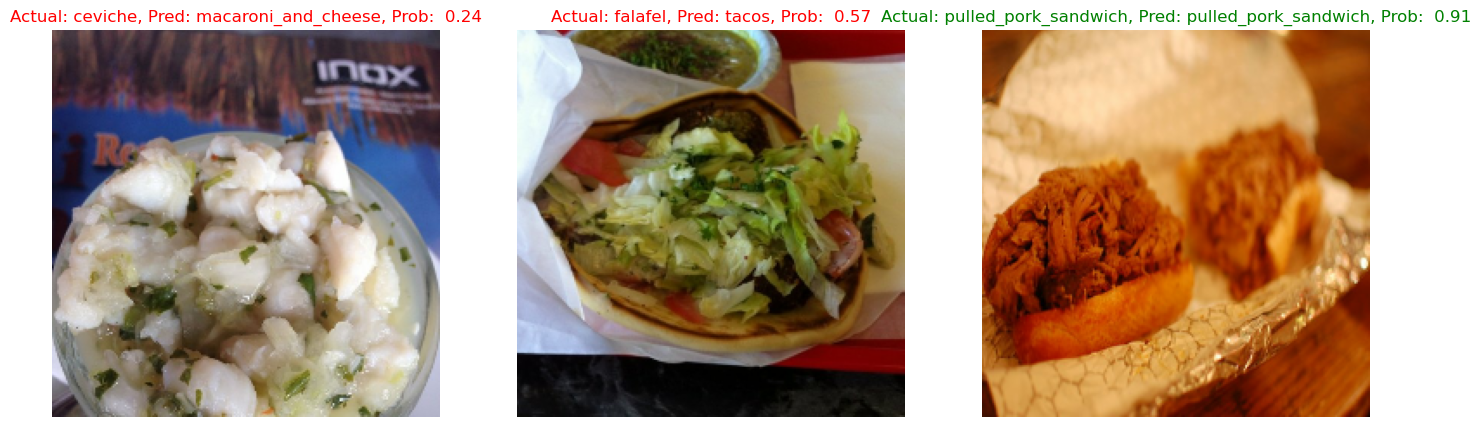

In [109]:
import random
import os

plt.figure(figsize=(17,10))
for i in range(3):
    class_name = random.choice(class_names)
    file_name = random.choice(os.listdir(test_dir + "/" + class_name))
    print(file_name)
    filepath = test_dir + "/" + class_name + '/' + file_name
    print(filepath)

    img = load_and_prep_image(filepath, scale=False)
    pred_prob = model_1.predict(tf.expand_dims(img, axis=0))
    pred_class = class_names[pred_prob.argmax()]
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class:
        title_color = 'g'
    else:
        title_color = 'r'
    plt.title(f"Actual: {class_name}, Pred: {pred_class}, Prob: {pred_prob.max(): .2f}", c=title_color)
    plt.axis(False)

## Finding the most wrong predictions

Meaning it has a high prediction probability but the prediction is incorrect. So the model was CONFIDENT that something was a certain label but the prediction was incorrect

In [87]:
filepaths = []
for filepath in test_data.list_files('101_food_classes_10_percent/test/*/*.jpg', shuffle=False):
    filepaths.append(filepath.numpy())
filepaths[:10]


[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [89]:
import pandas as pd

pred_df = pd.DataFrame({'img_path': filepaths, 'y_true': y_labels, 'y_pred': pred_classes, 'pred_conf': pred_probs.max(axis=1),
                        'y_true_class': [class_names[i] for i in y_labels], 'y_pred_class': [class_names[i] for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0      85   
1      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent/test/waffles/942...     100     100   
25246  b'101_food_classes_10_percent/test/waffles/954...     100     100   
25247  b'101_food_classes_10_percent/test/waffles/961...     100      56   
25248  b'101_food_classes_10_percent/test/waffles/970...     100      94   
25249  b'101_food_classes_10_percent/test/waffles/971...     100     100   

       pred_conf y_true_class          y_pred_class  
0       0.486614    apple_pie                samosa  
1       0.760075    apple_pie             apple_pie  
2       0.556273    apple_pie             apple_pie  
3       0.286094    apple_pie             apple_pie  
4       0.543221    apple_pie         bread_pudding  
...          ...          ...                   ...  
25245   0.890844      waffles               waffles  
25246   0.956755      waffles               waffles  
25247   0.562952      waffles      huevos_rancheros  
25248   0.251081      waffles  strawberry_shortcake  
25249   0.235829      waffles               waffles  

[25250 rows x 6 columns]

In [91]:
pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      85   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_class   y_pred_class  pred_correct  
0   0.486614    apple_pie         samosa         False  
1   0.760075    apple_pie      apple_pie          True  
2   0.556273    apple_pie      apple_pie          True  
3   0.286094    apple_pie      apple_pie          True  
4   0.543221    apple_pie  bread_pudding         False

In [93]:
#Sort the DF to have the most wrong predictions at the top
top_100_wrong = pred_df[pred_df['pred_correct']==False].sort_values('pred_conf', ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
4836   b'101_food_classes_10_percent/test/chicken_que...      19       9   
14482  b'101_food_classes_10_percent/test/hummus/8476...      57      51   
9690   b'101_food_classes_10_percent/test/fish_and_ch...      38      20   
9402   b'101_food_classes_10_percent/test/filet_migno...      37      79   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
17908  b'101_food_classes_10_percent/test/paella/3192...      71      65   
20067  b'101_food_classes_10_percent/test/pulled_pork...      80      53   
5114   b'101_food_classes_10_percent/test/chicken_win...      20      38   
403    b'101_food_classes_10_percent/test/baby_back_r...       1      20   
20191  b'101_food_classes_10_percent/test/pulled_pork...      80       9   
9227   b'101_food_classes_10_percent/test/falafel/676...      36      26   
17897  b'101_food_classes_10_percent/test/paella/2986...      71      65   
5006   b'101_food_classes_10_percent/test/chicken_win...      20      38   
18935  b'101_food_classes_10_percent/test/pho/3741977...      75      33   
10880  b'101_food_classes_10_percent/test/fried_calam...      43      68   
11697  b'101_food_classes_10_percent/test/garlic_brea...      46      35   
6757   b'101_food_classes_10_percent/test/creme_brule...      27      45   
9223   b'101_food_classes_10_percent/test/falafel/612...      36      26   
22658  b'101_food_classes_10_percent/test/spaghetti_b...      90      91   

       pred_conf          y_true_class         y_pred_class  pred_correct  
18001   0.997936              pancakes             omelette         False  
4836    0.997224    chicken_quesadilla    breakfast_burrito         False  
14482   0.996901                hummus            guacamole         False  
9690    0.996120        fish_and_chips        chicken_wings         False  
9402    0.994257          filet_mignon            prime_rib         False  
23797   0.994072                 sushi              sashimi         False  
17908   0.993848                paella              mussels         False  
20067   0.992795  pulled_pork_sandwich            hamburger         False  
5114    0.992438         chicken_wings       fish_and_chips         False  
403     0.990081        baby_back_ribs        chicken_wings         False  
20191   0.988881  pulled_pork_sandwich    breakfast_burrito         False  
9227    0.988310               falafel           crab_cakes         False  
17897   0.987857                paella              mussels         False  
5006    0.987571         chicken_wings       fish_and_chips         False  
18935   0.986107                   pho              edamame         False  
10880   0.985264        fried_calamari          onion_rings         False  
11697   0.984891          garlic_bread            escargots         False  
6757    0.983643          creme_brulee        frozen_yogurt         False  
9223    0.982979               falafel           crab_cakes         False  
22658   0.982243   spaghetti_bolognese  spaghetti_carbonara         False

In [96]:
top_100_wrong['img_path'].iloc[0]

b'101_food_classes_10_percent/test/pancakes/1008491.jpg'

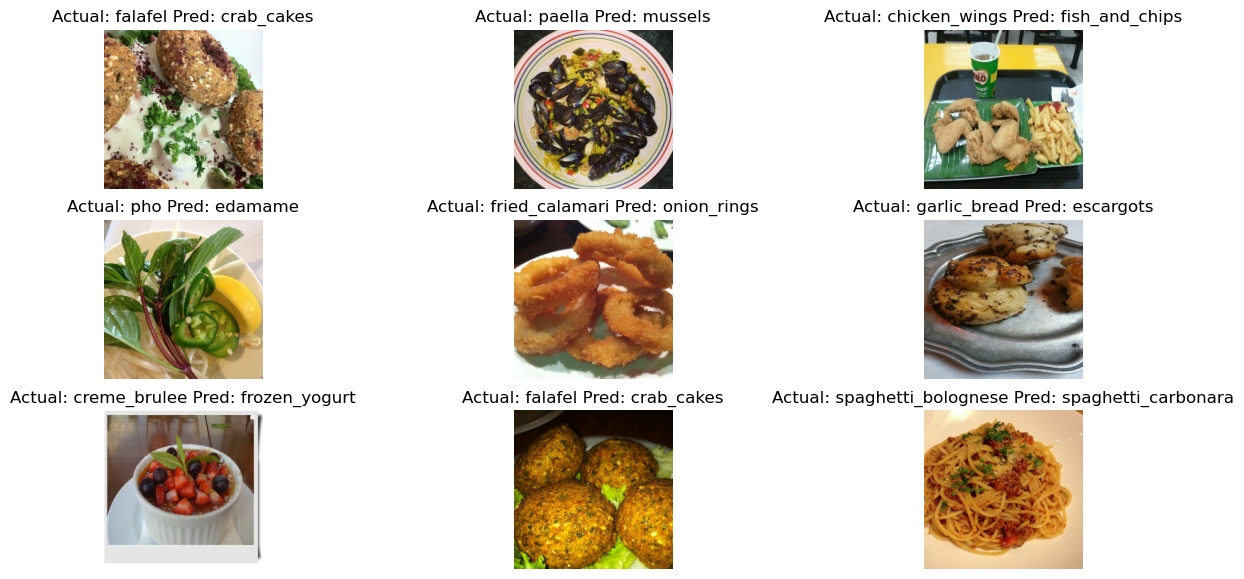

In [120]:
plt.figure(figsize=(15,7))
count = 0
for i in range(11, 20):
    plt.subplot(3,3, count+1)
    count += 1
    path = top_100_wrong['img_path'].iloc[i]
    img = load_and_prep_image(path)
    plt.imshow(img)
    plt.title(f'Actual: {top_100_wrong["y_true_class"].iloc[i]} Pred: {top_100_wrong["y_pred_class"].iloc[i]}')
    plt.axis(False)

In [121]:
custom_food_images = ['custom_food_images/' + img_path for img_path in os.listdir('custom_food_images/')]
custom_food_images

['custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg']

1/1 [==============================] - 0s 36ms/step


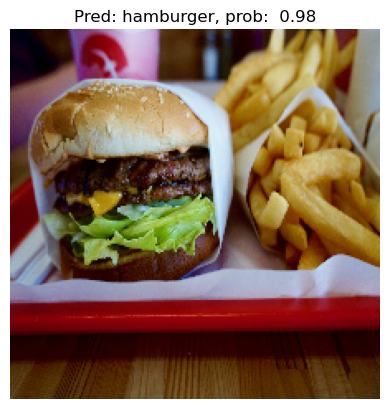

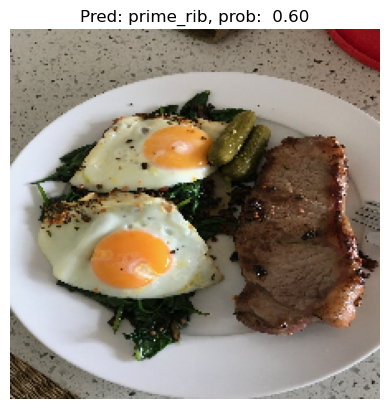

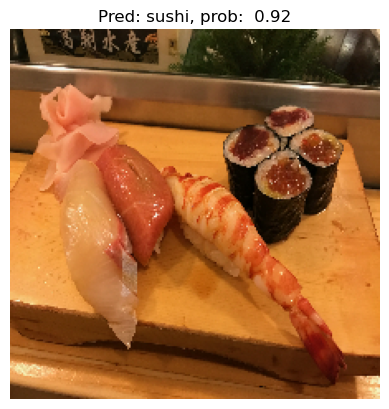

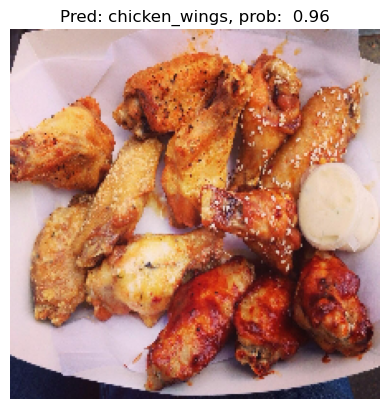

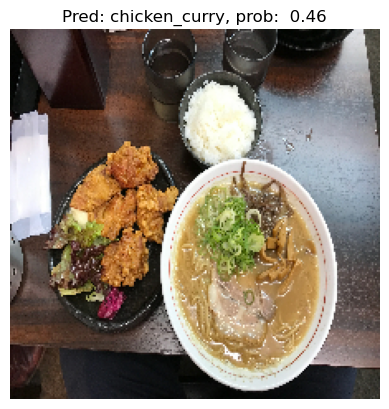

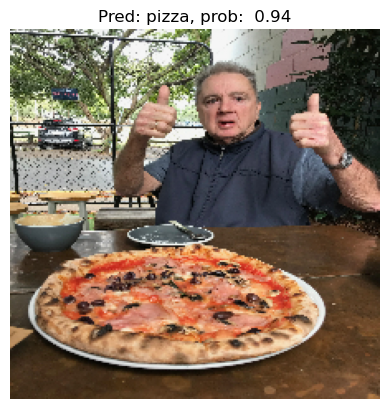

In [123]:
#Make Predictions on custom food images
for img in custom_food_images:
    img = load_and_prep_image(img, scale=False)
    pred_prob = model_1.predict(tf.expand_dims(img, axis=0))
    pred_class = class_names[pred_prob.argmax()]
    plt.figure()
    plt.imshow(img/255.)
    plt.title(f'Pred: {pred_class}, prob: {pred_prob.max(): .2f}')
    plt.axis(False)